In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt 
from scipy.signal import savgol_filter
from astropy.stats import sigma_clipped_stats as scs
import numpy as np

In [2]:
lc = fits.open("../xsm/data/2021/11/11/calibrated/ch2_xsm_20211111_v1_level2.lc")

In [3]:
lc.info()

Filename: ../xsm/data/2021/11/11/calibrated/ch2_xsm_20211111_v1_level2.lc
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   ()      
  1  RATE          1 BinTableHDU     64   14096R x 4C   [D, E, E, E]   


## Search for outliers

### Background subtraction 

In [4]:
counts = lc[1].data['RATE']
time = lc[1].data['TIME']

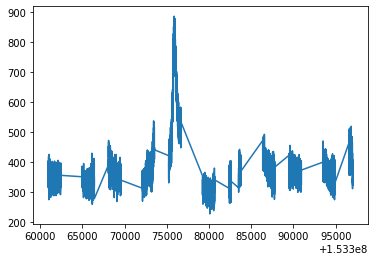

In [5]:
plt.plot(time, counts)

Need to split the .lc file into contiguous orbits

In [6]:
def orbit_start_indices(time, step=1):
    output_arr = []
    length_arr = []
    for i in range(len(time)):
        if(i==0):
            output_arr.append(i)
        elif(time[i]-time[i-1]>step):
            length_arr.append(time[i-1]-time[output_arr[-1]])
            output_arr.append(i)
    return output_arr, length_arr

In [7]:
orbit_start_indices(time, 2)

([0, 1438, 2877, 4363, 5801, 7284, 8720, 9008, 9327, 10762, 12238, 13672],
 [1485.0,
  1438.0,
  1485.0,
  1437.0,
  1482.0,
  1435.0,
  287.0,
  318.0,
  1434.0,
  1476.0,
  1433.0])

In [8]:
def distinct_orbits(arr, indices_array):
    output_arr = []
    for i in range(len(indices_array)):
        if(i==0):
            temp = arr[indices_array[0]:indices_array[1]]
            output_arr.append(temp)
        elif(i<len(indices_array)-1):
            temp = arr[indices_array[i]:indices_array[i+1]]
            output_arr.append(temp)
        else:
            temp = arr[indices_array[-1]:]
            output_arr.append(temp)
    return output_arr

In [9]:
def n_sigma(time, counts, n):
    '''n-sigma : returns indices where counts>(mean+n*sigma)
    Returns flags, mean, sigma'''
    mean,_, sigma = scs(counts)
    #flags = np.where(counts>(mean+n*sigma)
    flags = np.where(counts>(mean+n*sigma))
    return flags, mean, sigma

Need to rebin the data according to the minimum duration of burst being observed

In [10]:
def bin_edges_from_time(time, t_bin):
    time = np.array(time)
    bin_edges = (time[1:] + time[:-1])/2.0
    bin_edges = np.insert(bin_edges, 0, bin_edges[0] - t_bin)
    bin_edges = np.append(bin_edges,bin_edges[-1] + t_bin)
    return bin_edges

In [11]:
'''
flags, mean, sigma = n_sigma(time, counts, 3)
for orbit_num in range(len(time_split)):
    #run search on this
    plt.figure(orbit_num)
    print(mean, sigma)
    plt.plot(time_split[orbit_num], counts_split[orbit_num])
    plt.axhline(mean+3*sigma,linestyle='--', color='r')
    plt.axhline(mean, linestyle = '--', color='g')
'''

"\nflags, mean, sigma = n_sigma(time, counts, 3)\nfor orbit_num in range(len(time_split)):\n    #run search on this\n    plt.figure(orbit_num)\n    print(mean, sigma)\n    plt.plot(time_split[orbit_num], counts_split[orbit_num])\n    plt.axhline(mean+3*sigma,linestyle='--', color='r')\n    plt.axhline(mean, linestyle = '--', color='g')\n"

Splitting the lightcurve into orbits will not work as it becomes difficult to distinguish background variations from the actual solar burst (ask about duration, min, max)

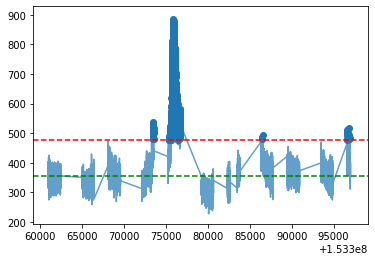

In [12]:
plt.figure(0)
flags, mean, sigma = n_sigma(time, counts, 3)
plt.plot(time, counts, alpha=0.7 )
plt.axhline(mean+3*sigma,linestyle='--', color='r')
plt.axhline(mean, linestyle = '--', color='g')
plt.scatter(time[flags], counts[flags])

Linear background fit 

In [13]:
from scipy.stats import linregress

In [14]:
slope, intercept, r, p, se = linregress(time, counts)

In [15]:
def background_corrected(time, counts, mode='linear'):
    '''time, rates 
    Returns background corrected rates'''
    if(mode == 'linear'):
        #linear for now 
        slope, intercept, r, p, se = linregress(time, counts)
        return counts - (slope*time + intercept)
    elif(mode == 'constant'):
        mean, _ , _ = scs(counts)
        return counts - mean

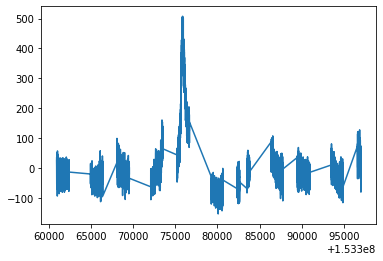

In [16]:
plt.figure(1)
plt.plot(time, background_corrected(time, counts))

Below function is piecewise 

In [17]:
def piece(bin_edges, bin_rates, t_bin):
    time = np.arange(bin_edges[0], bin_edges[-1], t_bin)
    #binning
    bin_widths = (bin_edges[1:] - bin_edges[:1])
    condlist=np.zeros((bin_rates.size, time.size), dtype=float)
    for i in range(bin_rates.size):
    #making condlist
        condlist[i] = (time>=bin_edges[i])&(time<bin_edges[i+1])
    rates = np.piecewise(x=time, condlist=condlist, funclist=bin_rates)
    return time, rates

## Make a new binning function 

In [18]:
def rebin_lc(time, rates, t_bin, t_bin_new):
    #t_bin_new is the new binning
    """time, rates
    t_bin : original binning in time
    t_bin_new : desired binning
    Returns time, rates (counts/s)"""
    new_time = np.arange(time[0]-t_bin/2 + t_bin_new/2, time[-1]+t_bin/2 + t_bin_new/2, t_bin_new)
    bin_edges = bin_edges_from_time(new_time, t_bin_new)
    bin_counts = np.histogram(time, bins = bin_edges, weights = rates)[0]
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    bin_rates = bin_counts/bin_widths
    return new_time, bin_rates

In [19]:
f_time = np.arange(0,20,1)
f_rates = np.random.randint(0, 5, size=(20))
new_time = np.arange(f_time[0]-1.0/2 + 4.0/2, f_time[-1]+1.0/2 - 4.0/2 + 4.0, 4.0)
bin_edges = bin_edges_from_time(new_time, 4.0)
#bin_edges = (new_time[1:]+new_time[:-1])/2
bin_counts = np.histogram(f_time, bins = bin_edges, weights = f_rates)[0]
bin_widths = bin_edges[1:] - bin_edges[:-1]
bin_rates = bin_counts/bin_widths

In [20]:
new_time

array([ 1.5,  5.5,  9.5, 13.5, 17.5])

In [21]:
bin_edges

array([-0.5,  3.5,  7.5, 11.5, 15.5, 19.5])

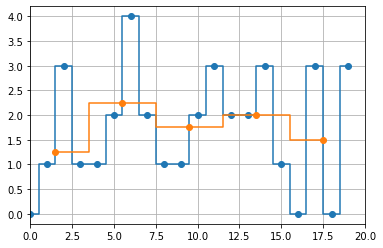

In [22]:
plt.plot(f_time, f_rates, '-o', drawstyle = 'steps-mid')
plt.plot(new_time, bin_rates, '-o',drawstyle = 'steps-mid')
plt.xlim(0,20)
plt.grid()

In [23]:
counts = background_corrected(time , counts)

In [24]:
time_new, counts_new = rebin_lc(time, counts, 1.0, 25.0)

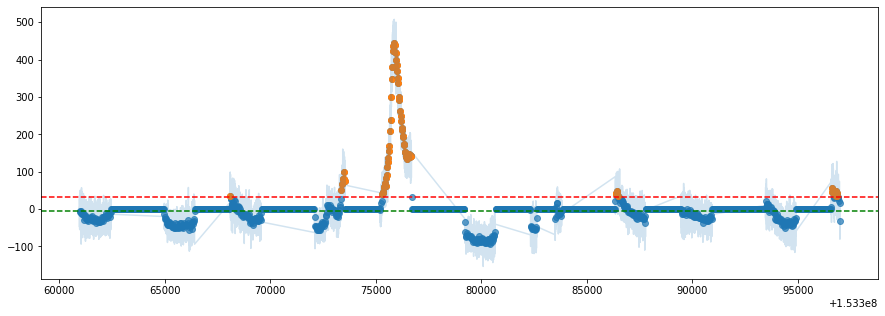

In [25]:
plt.figure(0, figsize=(15,5))
n=3
flags, mean, sigma = n_sigma(time_new, counts_new, n)
plt.scatter(time_new, counts_new, alpha=0.7)
plt.plot(time, counts, alpha=0.2)
plt.axhline(mean+n*sigma,linestyle='--', color='r')
plt.axhline(mean, linestyle = '--', color='g')
plt.scatter(time_new[flags], counts_new[flags])
#plt.xlim(1.533e8+74000, 1.533e8+77000)

In [26]:
time_new[flags]

array([1.53368098e+08, 1.53373373e+08, 1.53373398e+08, 1.53373423e+08,
       1.53373448e+08, 1.53373473e+08, 1.53373498e+08, 1.53373523e+08,
       1.53375298e+08, 1.53375323e+08, 1.53375348e+08, 1.53375373e+08,
       1.53375398e+08, 1.53375423e+08, 1.53375448e+08, 1.53375473e+08,
       1.53375498e+08, 1.53375523e+08, 1.53375548e+08, 1.53375573e+08,
       1.53375598e+08, 1.53375623e+08, 1.53375648e+08, 1.53375673e+08,
       1.53375698e+08, 1.53375723e+08, 1.53375748e+08, 1.53375773e+08,
       1.53375798e+08, 1.53375823e+08, 1.53375848e+08, 1.53375873e+08,
       1.53375898e+08, 1.53375923e+08, 1.53375948e+08, 1.53375973e+08,
       1.53375998e+08, 1.53376023e+08, 1.53376048e+08, 1.53376073e+08,
       1.53376098e+08, 1.53376123e+08, 1.53376148e+08, 1.53376173e+08,
       1.53376198e+08, 1.53376223e+08, 1.53376248e+08, 1.53376273e+08,
       1.53376298e+08, 1.53376323e+08, 1.53376348e+08, 1.53376373e+08,
       1.53376398e+08, 1.53376423e+08, 1.53376448e+08, 1.53376473e+08,
      

In [27]:
orb_idx, len_arr = orbit_start_indices(np.array(time_new[flags]).flatten(), 25.0)

In [28]:
orb_idx

[0, 1, 8, 64, 68, 69, 73]

In [29]:
len_arr

[0.0, 150.0, 1375.0, 75.0, 0.0, 75.0]

In [30]:
orb_idx

[0, 1, 8, 64, 68, 69, 73]

In [31]:
burst_start_idx = int(np.argmax(len_arr))
flags=np.array(flags).flatten()
burst_flags = flags[orb_idx[burst_start_idx] : orb_idx[burst_start_idx+1]]

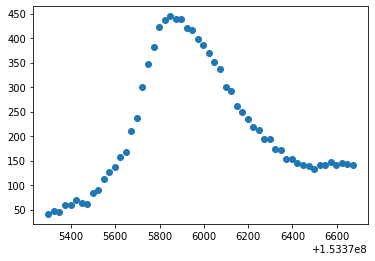

In [32]:
plt.scatter(time_new[burst_flags], counts_new[burst_flags])

In [33]:
from scipy.optimize import curve_fit

In [34]:
from scipy.special import erf

In [35]:
def EFP(x, A, B, C, D):
    Z = (2*B + C**2*D)/(2*C)
    return 1/2 * np.sqrt(np.pi) *  A * C * np.exp(D*(B-x) + C**2*D**2/4) * (erf(Z) - erf(Z - x/C))

/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


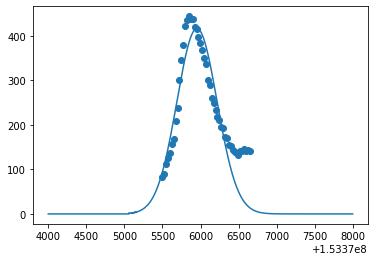

In [36]:
flags2 = np.arange(581, 628)

def EFP(x, A, B, C, D):
    Z = (2*B + C**2*D)/(2*C)
    return 1/2 * np.sqrt(np.pi) *  A * C * np.exp(D*(B-x) + C**2*D**2/4) * (erf(Z) - erf(Z - x/C))

popt, pcov = curve_fit(EFP, np.float128(time_new[flags2]), np.float128(counts_new[flags2]), p0 =([25, 6000+1.5337e8, 17, 0.1]))

#x2 = np.arange(1.533e8+75000, 1.533e8+77000)
x2 = np.arange(1.533e8+74000, 1.533e8+78000)
plt.scatter(time_new[flags2], counts_new[flags2])
plt.plot(x2, EFP(x2, *popt))
plt.savefig("efp_fit_1.png")

Should we ensure mean zero while fitting?

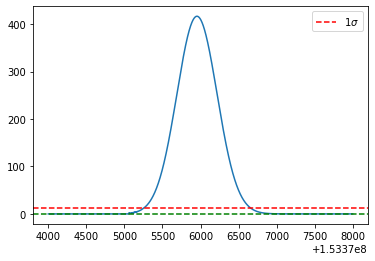

In [37]:
plt.plot(x2, EFP(x2, *popt))
plt.axhline(0+sigma,linestyle='--', color='r', label = "1$\sigma$")
plt.axhline(0, linestyle = '--', color='g')
#plt.scatter(time_new[flags2], counts_new[flags2])
plt.legend()

In [38]:
t_arr = x2[np.argwhere(np.diff(np.sign(EFP(x2, *popt) - sigma))).flatten()]
t_start = t_arr[0]
t_end = t_arr[-1]
t_max = x2[np.argmax(EFP(x2, *popt))]

In [39]:
print(t_start, t_end, t_max)

153375257.0 153376656.0 153375953.0


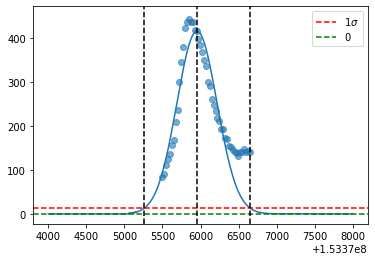

In [40]:
plt.plot(x2, EFP(x2, *popt))
plt.axhline(0+sigma,linestyle='--', color='r', label = "1$\sigma$")
plt.axhline(0, linestyle = '--', color='g', label = '0')
#plt.scatter(time_new[flags2], counts_new[flags2])
plt.axvline(t_start, ls = '--', color = 'k')
plt.axvline(t_end , ls = '--', color = 'k')
plt.axvline(t_max, ls = '--', color = 'k')
plt.scatter(time_new[flags2], counts_new[flags2], alpha=0.6)
plt.legend()


In [41]:
t_arr

array([1.53375257e+08, 1.53376656e+08])

In [42]:
mean, sigma

(-4.4291117477716675, 12.581264248004661)

In [43]:
counts_new[flags]

array([ 34.65706847,  51.97634632,  65.90208845,  80.94517312,
        81.38184788,  98.33700164,  81.67454431,  75.76715046,
        41.0379526 ,  46.04711149,  44.22903282,  59.64191607,
        59.96586012,  70.41096993,  64.17321964,  61.96372984,
        83.36356866,  90.10742237, 111.73032515, 125.59704995,
       136.61687534, 156.6701895 , 167.98801538, 209.24001606,
       237.42157363, 300.13763071, 347.12901494, 380.76806762,
       423.44006709, 437.06839223, 444.41921249, 438.45056987,
       438.71748144, 420.13584809, 416.51648524, 398.25837973,
       384.88952958, 368.66212718, 351.00113592, 336.83490785,
       300.44458065, 290.87252005, 261.70287401, 248.48653607,
       234.58716346, 217.78980013, 211.3682034 , 194.31132835,
       193.7869948 , 173.67186048, 170.70387703, 153.91250979,
       152.53437009, 144.82389153, 140.17103991, 138.04392439,
       132.77667336, 140.5957822 , 141.77452971, 146.97928918,
       140.44352497, 144.35441725, 141.94051706, 141.48

lc $\rightarrow$ time, rates $\rightarrow$ background correct $\rightarrow$ rebin $\rightarrow$ n-sigma $\rightarrow$ fit $\rightarrow$ t_arr

In [44]:
def load_lc(filename):
    '''filename : path to the .lc file
    Returns : time, rates'''
    lc = fits.open(filename)
    rates = lc[1].data['RATE']
    time = lc[1].data['TIME']
    return time, rates

In [45]:
'''time, rates = load_lc("../xsm/data/2021/11/11/calibrated/ch2_xsm_20211111_v1_level2.lc")
rates = background_corrected(time, rates)
n = 3
t_bin_new = 5.0
time_new, rates_new = rebin_lc(time, rates, 1.0, t_bin_new)
flags, mean, sigma = n_sigma(time_new, rates_new, n)
t2, fit2, time_burst, rates_burst = fit_efp(flags, time_new, rates_new, t_bin_new)
'''

'time, rates = load_lc("../xsm/data/2021/11/11/calibrated/ch2_xsm_20211111_v1_level2.lc")\nrates = background_corrected(time, rates)\nn = 3\nt_bin_new = 5.0\ntime_new, rates_new = rebin_lc(time, rates, 1.0, t_bin_new)\nflags, mean, sigma = n_sigma(time_new, rates_new, n)\nt2, fit2, time_burst, rates_burst = fit_efp(flags, time_new, rates_new, t_bin_new)\n'

In [46]:
from scipy.interpolate import CubicSpline

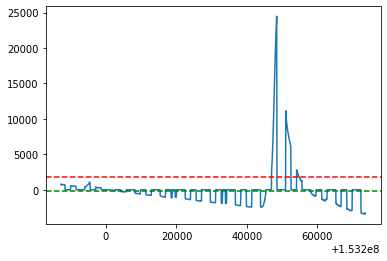

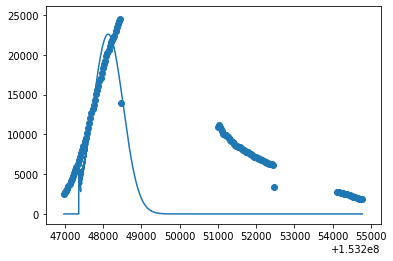

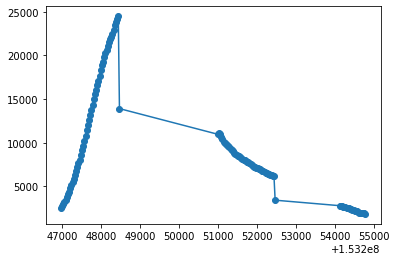

/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


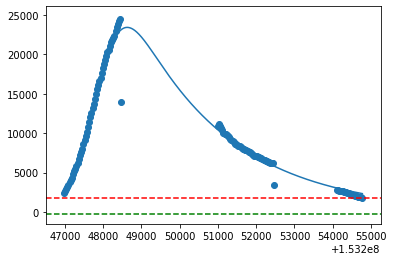

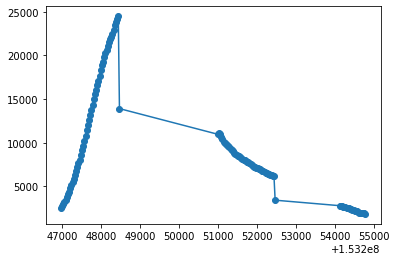

/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


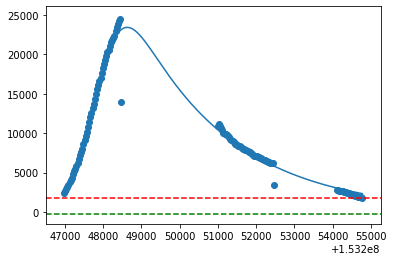

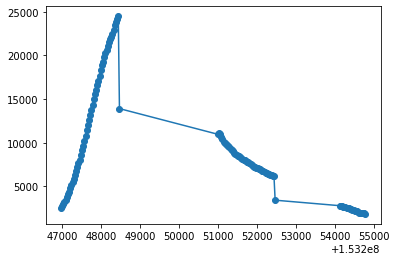

/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """
/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in multiply
  """


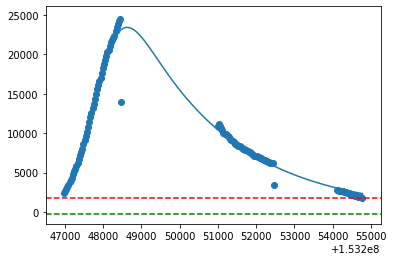

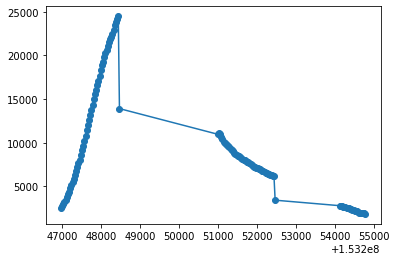

/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


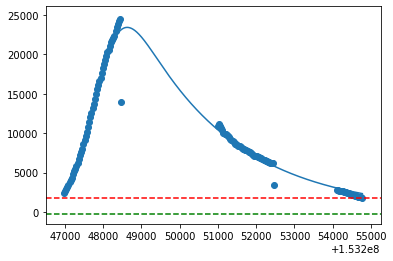

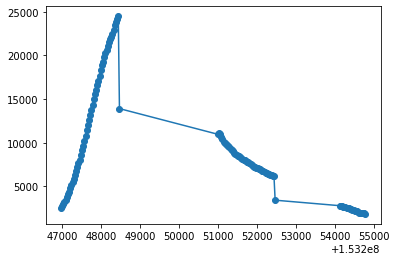

/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


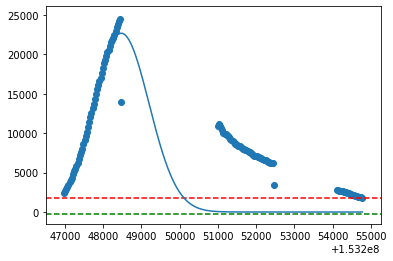

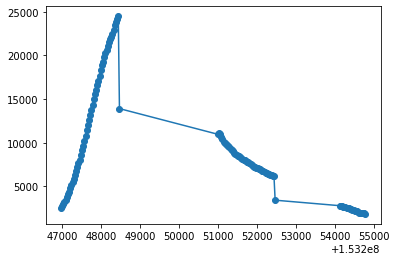

/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


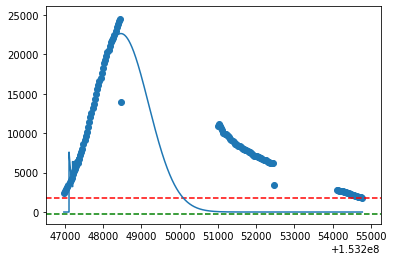

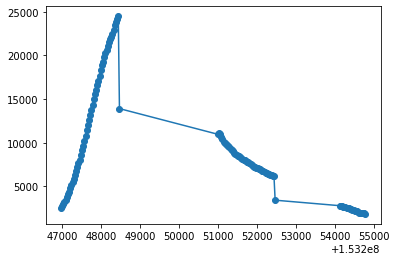

/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


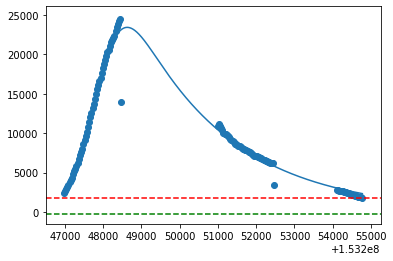

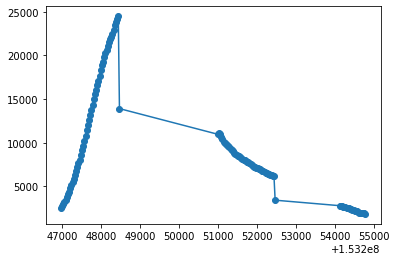

/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


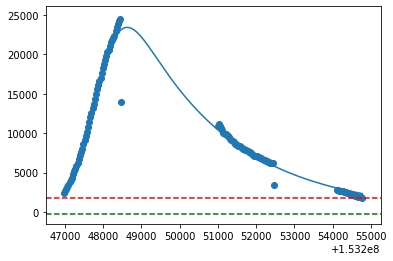

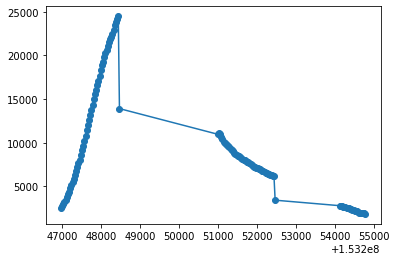

/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/pranav/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


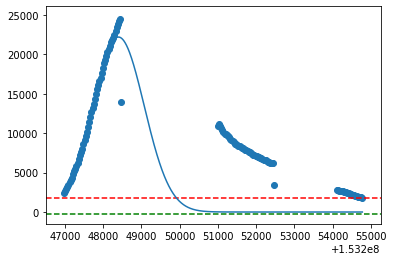

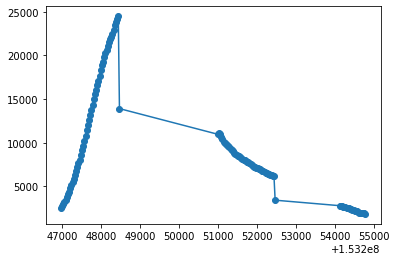

In [47]:
def fit_efp(flags, time, rates, t_bin_new, A0, B0, C0, D0):
    '''Returns fit'''
    #find the largest contiguous interval in flags
    orb_idx, len_arr = orbit_start_indices(np.array(time[flags]).flatten(), t_bin_new)
    burst_start_idx = int(np.argmax(len_arr))
    flags=np.array(flags).flatten()
    burst_flags = flags[orb_idx[burst_start_idx] : orb_idx[burst_start_idx+1]]
    #time_burst = time[burst_flags]
    #rates_burst = rates[burst_flags]
    time_burst = time[flags]
    rates_burst = rates[flags]
    t2 = np.linspace(time_burst[0], time_burst[-1], len(time_burst)*100)
    A0 *= np.sqrt(max(rates_burst))
    B0 *= time_burst[np.argmax(rates_burst)]
    C0 *= np.sqrt(max(rates_burst))
    popt, pcov = curve_fit(EFP, time_burst, rates_burst, p0 = [A0, B0 \
                                                               , C0, D0])
    fit2 = EFP(t2, *popt)
    return t2, fit2, time_burst, rates_burst
#-------------------------------------------
time, rates = load_lc("../xsm/data/2021/11/09/calibrated/ch2_xsm_20211109_v1_level2.lc")
rates = background_corrected(time, rates)
n = 3
t_bin_new = 30.0
time_new, rates_new = rebin_lc(time, rates, 1.0, t_bin_new)
plt.figure(0)
plt.plot(time_new, rates_new)

for i in range(10):
    flags, mean, sigma = n_sigma(time_new, rates_new, n)
    plt.axhline(mean+n*sigma,linestyle='--', color='r')
    plt.axhline(mean, linestyle = '--', color='g')
    t2, fit2, time_burst, rates_burst = fit_efp(flags, time_new, rates_new, t_bin_new, 1*i/10, 1, 1, 0.01)
    plt.figure(1)
    plt.plot(t2, fit2)
    #plt.xlim(1.529e8+72000, 1.529e8+76000)
    #plt.xlim(1.53e8+50000, 1.53e8+65000)
    plt.scatter(time_burst, rates_burst)
    plt.figure(2)
    cs = CubicSpline(time_burst, rates_burst)
    plt.scatter(time_burst, rates_burst)
    plt.plot(time_burst, cs(time_burst))
    plt.show()

look at binning function 

In [48]:
class lc:
    def __init__(self, filename, t_bin_new):
        self.filename = filename
        self.time, self.lc_rates = load_lc(filename)
        self.bc_rates = background_corrected(self.time, self.lc_rates, 'constant')
        self.binned_time, self.binned_rates = rebin_lc(self.time, self.lc_rates, 1.0, t_bin_new)
        

In [49]:
lc1 = lc("../xsm/data/2021/11/09/calibrated/ch2_xsm_20211109_v1_level2.lc", 20)

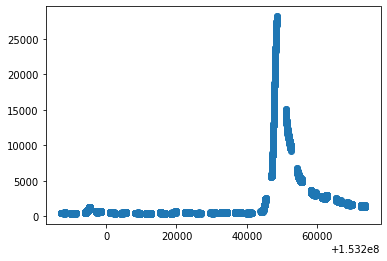

In [50]:
plt.scatter(lc1.time, lc1.lc_rates)